In [1]:
import pymssql
import pandas as pd

Read In Tables From Database

In [2]:
database = "group4"
mortalityTable = "dbo.mortality"
underweightTable = "dbo.underweight"
waterTable = "dbo.water"
malariaTable = "dbo.malaria"
tbTable = "dbo.tb"
user = "group4user"
password  = "everythingIsAwesome!"
server = "database2108.database.windows.net"

In [3]:
conn = pymssql.connect(server, user, password, database)

dfMortal = pd.read_sql(f"SELECT * FROM {mortalityTable}", conn)
dfUnder = pd.read_sql(f"SELECT * FROM {underweightTable}", conn)
dfWater = pd.read_sql(f"SELECT * FROM {waterTable}", conn)
dfMalaria = pd.read_sql(f"SELECT * FROM {malariaTable}", conn)
dfTb = pd.read_sql(f"SELECT * FROM {tbTable}", conn)

display(dfMortal)
display(dfUnder)
display(dfWater)
display(dfMalaria)
display(dfTb)

,Country,Year,PercentMortality
0,AFG,2000,31.6
1,AFG,2001,30.7
2,AFG,2002,29.2
3,AFG,2003,28.6
4,AFG,2004,28.2
...,...,...,...
3106,ZWE,2012,40.7
3107,ZWE,2013,38.3
3108,ZWE,2014,35.8
3109,ZWE,2015,34.6


,Country,PercentUnderweightAdults,Year
0,AFG,29.200001,1975
1,AFG,28.900000,1976
2,AFG,28.700001,1977
3,AFG,28.400000,1978
4,AFG,28.100000,1979
...,...,...,...
8143,ZWE,8.300000,2012
8144,ZWE,8.200000,2013
8145,ZWE,8.100000,2014
8146,ZWE,8.000000,2015


,Country,Year,PercentWater
0,AFG,2000,28.171419
1,AFG,2001,28.199369
2,AFG,2002,30.236380
3,AFG,2003,32.273720
4,AFG,2004,34.328560
...,...,...,...
3327,ZWE,2012,66.491180
3328,ZWE,2013,65.966469
3329,ZWE,2014,65.454109
3330,ZWE,2015,64.954933


,Country,Year,PercentMalaria
0,ABW,2000,0.0
1,ABW,2001,0.0
2,ABW,2002,0.0
3,ABW,2003,0.0
4,ABW,2004,0.0
...,...,...,...
4211,ZWE,2012,5.7
4212,ZWE,2013,8.1
4213,ZWE,2014,10.1
4214,ZWE,2015,9.7


,Country,Year,PercentTb
0,AFG,2000,0.190
1,AFG,2001,0.189
2,AFG,2002,0.189
3,AFG,2003,0.189
4,AFG,2004,0.189
...,...,...,...
3459,ZWE,2016,0.233
3460,ZWE,2017,0.221
3461,ZWE,2018,0.210
3462,ZWE,2019,0.199


Joined Tables To Create Features Table

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

joined = dfWater.merge(dfUnder, on = ["Country", "Year"]) \
                .merge(dfMortal, on = ["Country", "Year"]) \
                .merge(dfMalaria, on = ["Country", "Year"]) \
                .merge(dfTb, on = ["Country", "Year"])

display(joined)

,Country,Year,PercentWater,PercentUnderweightAdults,PercentMortality,PercentMalaria,PercentTb
0,AFG,2000,28.171419,22.000000,31.6,8.2,0.190
1,AFG,2001,28.199369,21.600000,30.7,7.9,0.189
2,AFG,2002,30.236380,21.299999,29.2,7.9,0.189
3,AFG,2003,32.273720,20.900000,28.6,6.8,0.189
4,AFG,2004,34.328560,20.600000,28.2,3.7,0.189
...,...,...,...,...,...,...,...
3083,ZWE,2012,66.491180,8.300000,40.7,5.7,0.355
3084,ZWE,2013,65.966469,8.200000,38.3,8.1,0.304
3085,ZWE,2014,65.454109,8.100000,35.8,10.1,0.278
3086,ZWE,2015,64.954933,8.000000,34.6,9.7,0.242


Split Set into Training and Testing Sets

In [5]:
from sklearn.model_selection import train_test_split
X = joined.drop(["Country", "PercentMortality"], axis = 1)
y = joined["PercentMortality"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 0)

Run Grid Search on Best Performing Model from Manual Tests

In [6]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
# Capped Number of Estimators to 150 so training times don't get too long
estimators = np.linspace(60, 150, 10, dtype = int)
parameters = {'random_state': [0], 'n_estimators': estimators,
              'criterion': ["squared_error", "absolute_error"]}
clf = GridSearchCV(ExtraTreesRegressor(), parameters, verbose = 4)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END criterion=squared_error, n_estimators=60, random_state=0;, score=0.949 total time=   0.2s
[CV 2/5] END criterion=squared_error, n_estimators=60, random_state=0;, score=0.933 total time=   0.2s
[CV 3/5] END criterion=squared_error, n_estimators=60, random_state=0;, score=0.961 total time=   0.2s
[CV 4/5] END criterion=squared_error, n_estimators=60, random_state=0;, score=0.953 total time=   0.2s
[CV 5/5] END criterion=squared_error, n_estimators=60, random_state=0;, score=0.969 total time=   0.2s
[CV 1/5] END criterion=squared_error, n_estimators=70, random_state=0;, score=0.949 total time=   0.2s
[CV 2/5] END criterion=squared_error, n_estimators=70, random_state=0;, score=0.933 total time=   0.2s
[CV 3/5] END criterion=squared_error, n_estimators=70, random_state=0;, score=0.962 total time=   0.2s
[CV 4/5] END criterion=squared_error, n_estimators=70, random_state=0;, score=0.953 total time=   0.3s
[CV 5/5] EN

[CV 5/5] END criterion=absolute_error, n_estimators=110, random_state=0;, score=0.968 total time=   6.8s
[CV 1/5] END criterion=absolute_error, n_estimators=120, random_state=0;, score=0.952 total time=   6.6s
[CV 2/5] END criterion=absolute_error, n_estimators=120, random_state=0;, score=0.936 total time=   5.3s
[CV 3/5] END criterion=absolute_error, n_estimators=120, random_state=0;, score=0.964 total time=   5.7s
[CV 4/5] END criterion=absolute_error, n_estimators=120, random_state=0;, score=0.954 total time=   5.5s
[CV 5/5] END criterion=absolute_error, n_estimators=120, random_state=0;, score=0.968 total time=   5.3s
[CV 1/5] END criterion=absolute_error, n_estimators=130, random_state=0;, score=0.952 total time=   5.8s
[CV 2/5] END criterion=absolute_error, n_estimators=130, random_state=0;, score=0.935 total time=   5.6s
[CV 3/5] END criterion=absolute_error, n_estimators=130, random_state=0;, score=0.964 total time=   6.0s
[CV 4/5] END criterion=absolute_error, n_estimators=130

GridSearchCV(estimator=ExtraTreesRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'n_estimators': array([ 60,  70,  80,  90, 100, 110, 120, 130, 140, 150]),
                         'random_state': [0]},
             verbose=4)

{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
0.9684310847710305


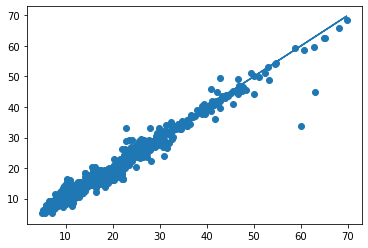

In [7]:
import matplotlib.pyplot as plt
bclf = clf.best_estimator_
print(bclf.get_params())
bclf.fit(X_train, y_train)
print(bclf.score(X_test, y_test))

prediction = bclf.predict(X_test)
plt.scatter(y_test, prediction)
plt.plot(y_test, y_test)

Export Best Found Model from the Grid Search

In [9]:
import pickle
pickle.dump(bclf, open("./Model/extratrees.pkl", "wb"))

Manual Tests of Other Models

0.8786762209597462


C:\Users\agang_drcif5q\miniconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\agang_drcif5q\miniconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


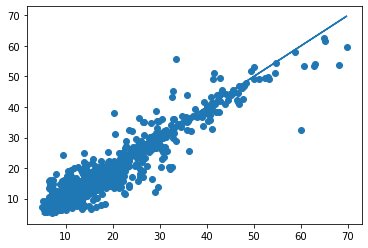

In [10]:
# from sklearn.neighbors import KNeighborsRegressor
# knr = KNeighborsRegressor(n_neighbors = 3, weights = "distance", p = 1)
# knr.fit(X_train, y_train)

# print(knr.score(X_test, y_test))

# prediction = knr.predict(X_test)
# plt.scatter(y_test, prediction)
# plt.plot(y_test, y_test)

C:\Users\agang_drcif5q\miniconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RadiusNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\agang_drcif5q\miniconda3\lib\site-packages\sklearn\neighbors\_regression.py:474: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


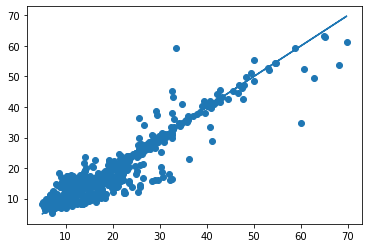

In [11]:
# from sklearn.neighbors import RadiusNeighborsRegressor
# rnr = RadiusNeighborsRegressor(radius = 4, weights = "distance", p = 1)
# rnr.fit(X_train, y_train)

# # print(rnr.score(X_test, y_test))

# prediction = rnr.predict(X_test)
# plt.scatter(y_test, prediction)
# plt.plot(y_test, y_test)

-0.6451381595016132


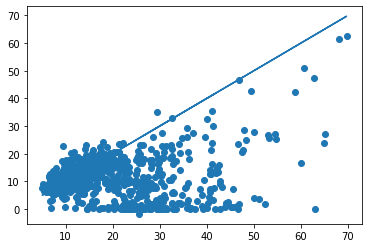

In [12]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# gpr = GaussianProcessRegressor(alpha = 0.01, random_state = 0)
# gpr.fit(X_train, y_train)

# print(gpr.score(X_test, y_test))

# prediction = gpr.predict(X_test)
# plt.scatter(y_test, prediction)
# plt.plot(y_test, y_test)

0.9376229925614575


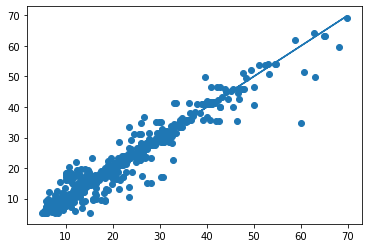

In [13]:
# from sklearn.tree import DecisionTreeRegressor
# dtr = DecisionTreeRegressor(random_state = 0, criterion = "absolute_error", min_samples_split = 5)
# dtr.fit(X_train, y_train)

# print(dtr.score(X_test, y_test))

# prediction = dtr.predict(X_test)
# plt.scatter(y_test, prediction)
# plt.plot(y_test, y_test)

0.9542749216903018


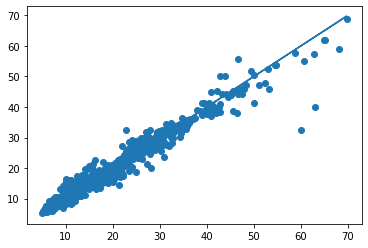

In [14]:
# from sklearn.ensemble import RandomForestRegressor
# rfr = RandomForestRegressor(random_state = 0, n_estimators = 80, criterion = "absolute_error")
# rfr.fit(X_train, y_train)

# print(rfr.score(X_test, y_test))

# prediction = rfr.predict(X_test)
# plt.scatter(y_test, prediction)
# plt.plot(y_test, y_test)

0.9114083225060375


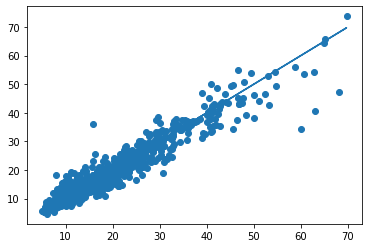

In [53]:
# from sklearn.ensemble import GradientBoostingRegressor
# gbr = GradientBoostingRegressor(random_state = 0, loss = "squared_error",
#                                 n_estimators = 500, learning_rate = 0.5)
# gbr.fit(X_train, y_train)

# print(gbr.score(X_test, y_test))

# prediction = gbr.predict(X_test)
# plt.scatter(y_test, prediction)
# plt.plot(y_test, y_test)